In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/set/combined_data.csv')
df

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...
...,...,...
83443,0,hi given a date how do i get the last date of ...
83444,1,now you can order software on cd or download i...
83445,1,dear valued member canadianpharmacy provides a...
83446,0,subscribe change profile contact us long term ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

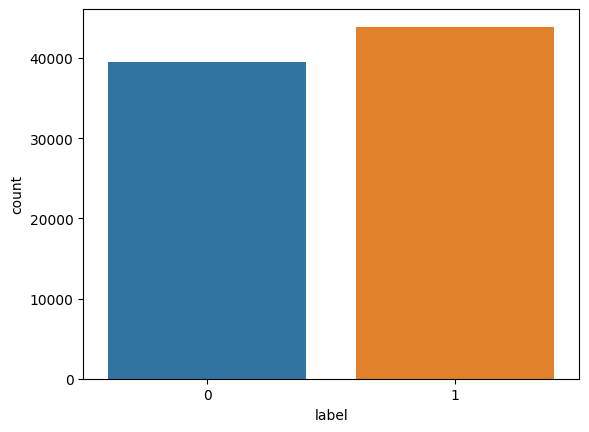

In [5]:
sns.countplot(x = 'label', data = df)
plt.show()

In [6]:
labels = {0 : "Not Spam", 1 : "Spam"}
label_counts = df['label'].value_counts()
print(label_counts)

1    43910
0    39538
Name: label, dtype: int64


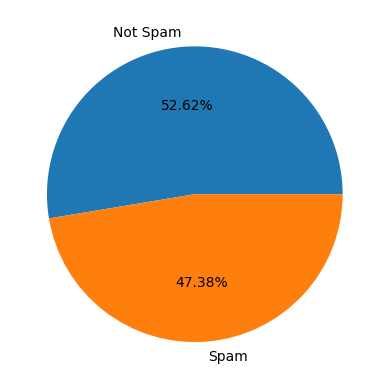

In [7]:
plt.pie(label_counts, labels = labels.values(), autopct = "%.2f%%")
plt.show()

In [8]:
df.groupby(df['label']).describe()


text                                                               
       count unique                                                top freq
label                                                                      
0      39538  39538   computer connection from cnn com wednesday es...    1
1      43910  43910  ounce feather bowl hummingbird opec moment ala...    1

In [9]:
df.isna().sum()


label    0
text     0
dtype: int64

In [10]:
print(f"Number of duplicated urls : {np.sum(df.duplicated())}")

df.drop_duplicates(inplace = True)

print(f"Number of duplicated urls (after dropping duplicates) : {np.sum(df.duplicated())}")

Number of duplicated urls : 0
Number of duplicated urls (after dropping duplicates) : 0


In [11]:
df.shape

(83448, 2)

In [12]:
train_texts = df['text'].tolist()
train_labels = df['label'].tolist()

In [13]:
from sklearn.model_selection import train_test_split

train_texts, test_texts,train_labels,test_labels = train_test_split(train_texts,train_labels,test_size =.2,random_state=55,shuffle = True)
train_texts, val_texts,train_labels,val_labels = train_test_split(train_texts,train_labels,test_size =.2,random_state=55,shuffle = True)

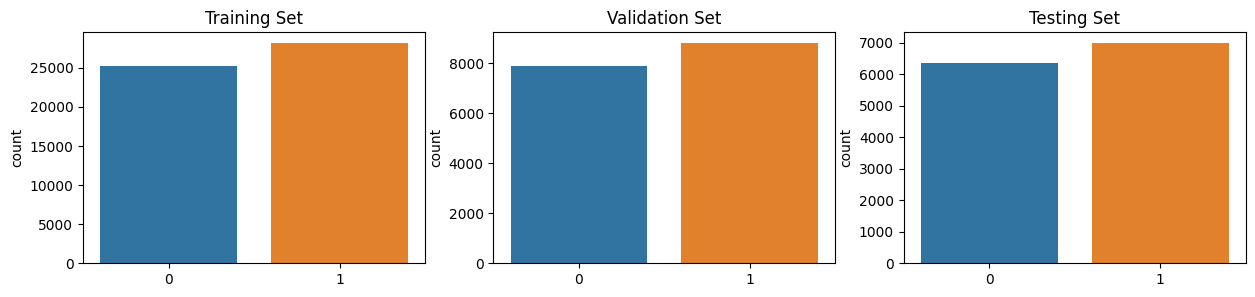

In [14]:
# Checking whether the labels are distributed uniformely

plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.title("Training Set")
sns.countplot(x=train_labels)

plt.subplot(1, 3, 2)
plt.title("Validation Set")
sns.countplot(x=test_labels)

plt.subplot(1, 3, 3)
plt.title("Testing Set")
sns.countplot(x=val_labels)

plt.show()

In [15]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [16]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [17]:
import torch

class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SpamDataset(train_encodings, train_labels)
test_dataset = SpamDataset(test_encodings, test_labels)
val_dataset = SpamDataset(val_encodings,val_labels)


In [18]:
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.9 MB/s eta 0:00:00


In [19]:
from transformers import RobertaForSequenceClassification
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = RobertaForSequenceClassification.from_pretrained('roberta-base')
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size = 8,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size = 8,shuffle=True)

optim = torch.optim.AdamW(model.parameters(), lr=2e-6)

training_losses = []
validation_losses = []
testing_losses = []
testing_predictions = []
testing_labels = []

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
for epoch in range(2):
  #Training
  model.train()
  for step,batch in enumerate(train_loader):
      optim.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs[0]
      loss.backward()
      optim.step()

      training_losses.append(loss.item())

      if step % 500 == 0:
        print(f'Training - Epoch: {epoch}, Step: {step}, Loss: {loss.item()}')

  # Validation
  model.eval()
  with torch.no_grad():
    val_loss = 0.0
    val_steps = 0
    for val_batch in val_loader:
      input_ids = val_batch['input_ids'].to(device)
      attention_mask = val_batch['attention_mask'].to(device)
      labels = val_batch['labels'].to(device)
      val_outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      val_loss += val_outputs[0].item()
      val_steps += 1

      average_val_loss = val_loss / val_steps
      validation_losses.append(average_val_loss)

      if val_steps % 300 == 0:
        print(f'Validation - Epoch: {epoch}, Average Loss: {average_val_loss}')



Training - Epoch: 0, Step: 0, Loss: 0.7022727131843567
Training - Epoch: 0, Step: 500, Loss: 0.019160520285367966
Training - Epoch: 0, Step: 1000, Loss: 0.014003312215209007
Training - Epoch: 0, Step: 1500, Loss: 0.03238627314567566
Training - Epoch: 0, Step: 2000, Loss: 0.2485741227865219
Training - Epoch: 0, Step: 2500, Loss: 0.2131124883890152
Training - Epoch: 0, Step: 3000, Loss: 0.006309604737907648
Validation - Epoch: 0, Average Loss: 0.02994224309261578
Validation - Epoch: 0, Average Loss: 0.028216045565980796
Validation - Epoch: 0, Average Loss: 0.02587807114365407
Validation - Epoch: 0, Average Loss: 0.029110167732045132
Validation - Epoch: 0, Average Loss: 0.030628760406553435
Training - Epoch: 1, Step: 0, Loss: 0.004479491151869297


KeyboardInterrupt: ignored

In [21]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    test_steps = 0

    for test_batch in test_loader:
        input_ids = test_batch['input_ids'].to(device)
        attention_mask = test_batch['attention_mask'].to(device)
        labels = test_batch['labels'].to(device)

        test_outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        test_loss += test_outputs[0].item()
        test_steps += 1

        average_test_loss = test_loss / test_steps
        testing_losses.append(average_test_loss)

        if test_steps % 150 == 0:
          print(f'Test - Average Loss: {average_test_loss}')

        # Collecting predictions and labels for further analysis
        testing_predictions.extend(torch.argmax(test_outputs.logits, dim=1).cpu().numpy())
        testing_labels.extend(labels.cpu().numpy())

        del input_ids, attention_mask, labels, test_outputs
        torch.cuda.empty_cache()

# Calculate accuracy on the test set
test_accuracy = accuracy_score(testing_labels, testing_predictions)
print(f'Test Accuracy: {test_accuracy}')

Test - Average Loss: 0.044440999522339555
Test - Average Loss: 0.04504598850287342
Test - Average Loss: 0.04381883381089816
Test - Average Loss: 0.044665031478216405
Test - Average Loss: 0.04545555003639311
Test - Average Loss: 0.04468481667042296
Test - Average Loss: 0.04406920047937005
Test - Average Loss: 0.04340182243710539
Test - Average Loss: 0.04239470795961097
Test - Average Loss: 0.04552522533480078
Test - Average Loss: 0.04614283532338132
Test - Average Loss: 0.04688031823209409
Test - Average Loss: 0.04639319595361415
Test Accuracy: 0.984661473936489


In [33]:
# Using for simple testing

device = "cuda" if torch.cuda.is_available() else "cpu"
text = "Subject: day off tuesday  stinson ,  i would like to take a day off tomorrow ( tuesday , april 10 ) .  i need to register my son to elementary school and send my cars to service .  my cell number is 713 - 858 - 2577 in case you need to reach me .  zimin"
ids = tokenizer.encode(text,add_special_tokens = True, return_tensors = "pt").to(device)
model.to(device)
with torch.no_grad():
  output = model(ids)

logits = output.logits
predicted_class = torch.argmax(logits,dim=1).item()

print(f"Predicted class : {predicted_class}")

Predicted class : 0


In [23]:
model.save_pretrained('spam-detection-model')

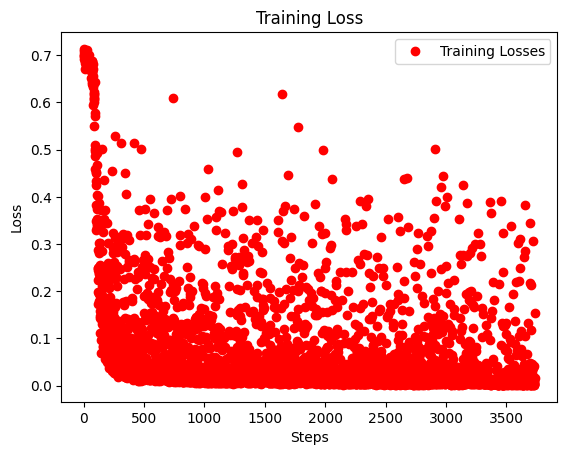

In [24]:
train_steps = range(1, len(training_losses) + 1)

# Plotting testing losses
plt.plot(train_steps, training_losses, 'ro', label='Training Losses')
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

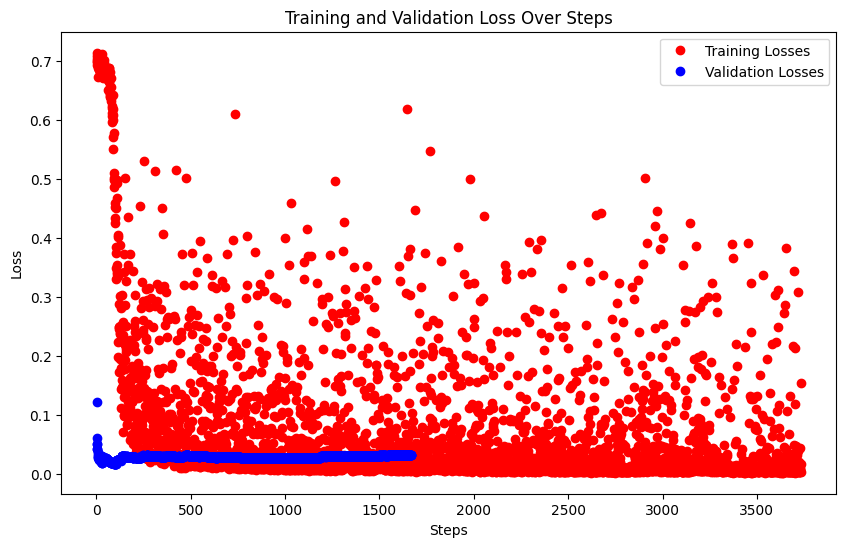

In [29]:
train_steps = range(1, len(training_losses) + 1)
val_steps = range(1,len(validation_losses) + 1)


# Plotting testing losses
plt.figure(figsize=(10, 6))
plt.plot(train_steps, training_losses, 'ro', label='Training Losses',linewidth=2)
plt.plot(val_steps, validation_losses, 'bo', label='Validation Losses',linewidth=2)
plt.title('Training and Validation Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

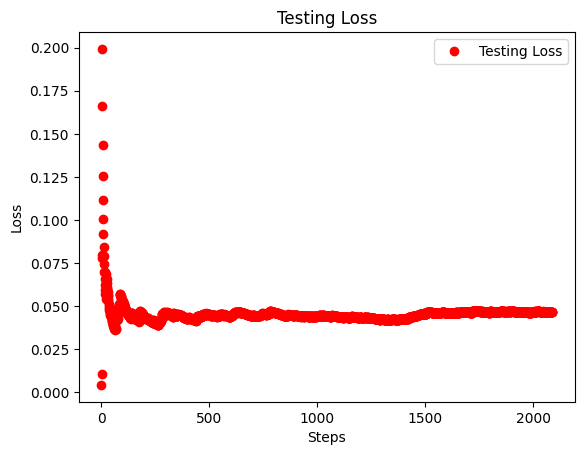

In [26]:
test_steps = range(1, len(testing_losses) + 1)

# Plotting testing losses
plt.plot(test_steps, testing_losses, 'ro', label='Testing Loss')
plt.title('Testing Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

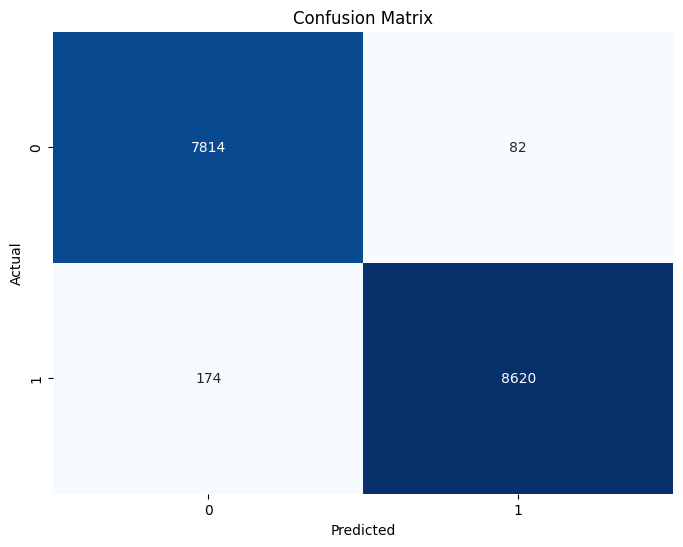

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testing_labels, testing_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

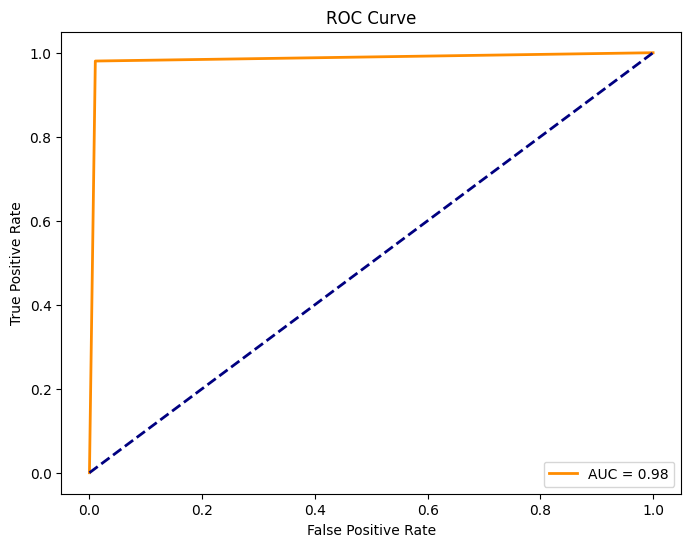

In [28]:
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(testing_labels, testing_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()